# Content

Time series clustering using K means with Euclidean and DTW distance

In [1]:
%matplotlib inline
from tslearn.clustering import silhouette_score

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 8]

from tslearn.clustering import TimeSeriesKMeans
import pandas as pd
import matplotlib
import json


/Users/kaan/opt/anaconda3/envs/evaluative_trajectories_2/lib/python3.9/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# Preparing the data

In [2]:
data = pd.read_csv('./data/data_long.csv')

def listify(row):
    row = str(row).replace('[', '').replace(']', '').split(',')
    row = [float(y) for y in row]

    return np.asarray(row)

data.loc[:, 'points'] = data.loc[:, 'points'].apply(listify)
points = data['points']

In [3]:

points = np.array(points.values.tolist())
points.resize(points.shape[0], 900, 1)
print(points.shape)

(1728, 900, 1)


In [4]:
seed = 10
np.random.seed(seed)
X_train = points
sz = X_train.shape[1]

In [5]:

print(np.mean(X_train[1,:]))
print(np.std(X_train[1,:]))

64.16760421441155
31.99767459851701


#### Looking at some of the patterns

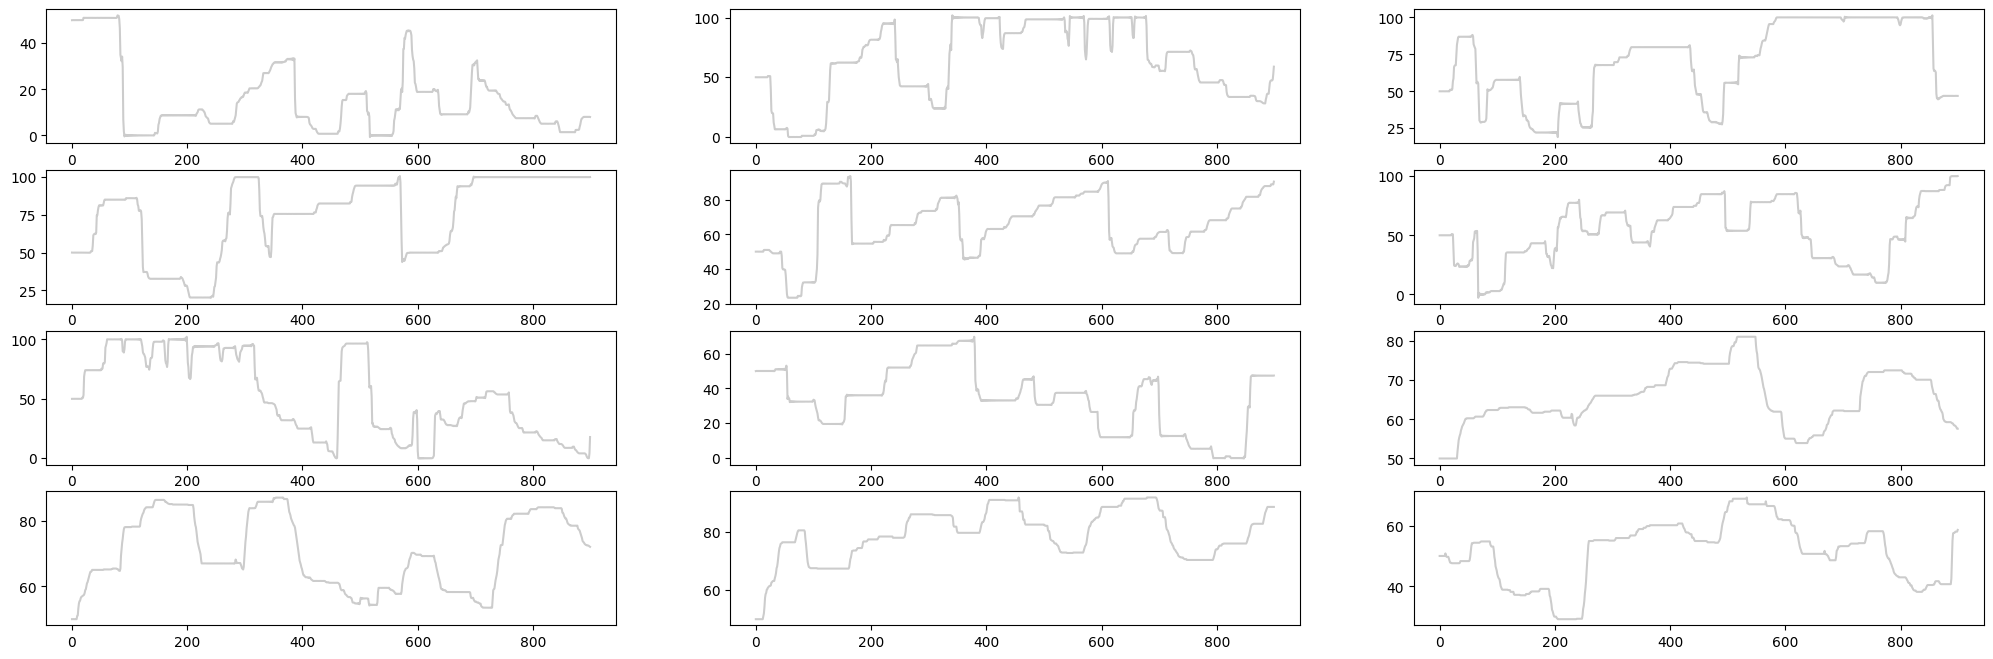

In [6]:
for yi in range(12):
    plt.subplot(4, 3, yi + 1)
    plt.plot(X_train[yi].ravel(), "k-", alpha=.2)

## Training the model and saving the results
  * Using Euclidean distance

In [7]:
# Euclidean k-means

seed = 10
np.random.seed(seed)


n_clusterss = [27]

for n_clusters in n_clusterss:
    print("Euclidean k-means ---- {}".format(n_clusters))
    km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, random_state=seed, n_jobs=-1)
    cluster_labels = km.fit_predict(X_train)

    centers = []
    for i in range(0, 27):
        centers.append(list(km.cluster_centers_[i].flatten()))

    pd.DataFrame(np.asarray(centers).transpose()).to_csv("./data/cluster_centers.csv")

    print("Euclidean silhoutte: {:.2f}".format(silhouette_score(X_train, cluster_labels, metric="euclidean")))

    # Plot each average curve independently:
    for yi in range(n_clusters):
        plt.plot(km.cluster_centers_[yi].ravel(), "r-", linewidth=40)
        plt.tight_layout()

        plt.xlim(0, sz)
        plt.ylim(0, 100)
        plt.axis('off')

        fig = matplotlib.pyplot.gcf()
        fig.set_size_inches(18.5, 18.5)

        plt.savefig("./plots/cluster/cluster_{}_{}.png".format(yi, n_clusters))
        plt.close()

    fig = plt.figure()
    for yi in range(n_clusters):
        ax = plt.subplot(9, 3, yi + 1)
        for xx in X_train[cluster_labels == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(km.cluster_centers_[yi].ravel(), "r-")

        plt.xlim(0, sz)
        plt.ylim(0, 100)
        plt.text(0.37, 1.05,'Cluster %d' % (yi + 1),
                 transform=plt.gca().transAxes, fontsize=20, fontweight='bold')

        print("Cluster {} done!".format(yi))

    data['cluster_labels'] = cluster_labels
    data.to_csv("./data/data_long_cluster_{}.csv".format(str(n_clusters)))
    plt.tight_layout(pad=1.2, h_pad=1.5)

    fig = matplotlib.pyplot.gcf()
    #fig.set_size_inches(10, 20)
    
    plt.savefig("./plots/cluster/k_means_{}.png".format(str(n_clusters)), dpi=700)
    plt.close()

Euclidean k-means ---- 27
Euclidean silhoutte: 0.11
Cluster 0 done!
Cluster 1 done!
Cluster 2 done!
Cluster 3 done!
Cluster 4 done!
Cluster 5 done!
Cluster 6 done!
Cluster 7 done!
Cluster 8 done!
Cluster 9 done!
Cluster 10 done!
Cluster 11 done!
Cluster 12 done!
Cluster 13 done!
Cluster 14 done!
Cluster 15 done!
Cluster 16 done!
Cluster 17 done!
Cluster 18 done!
Cluster 19 done!
Cluster 20 done!
Cluster 21 done!
Cluster 22 done!
Cluster 23 done!
Cluster 24 done!
Cluster 25 done!
Cluster 26 done!


In [ ]:
####### Convert cluster centers to polynomials #######

def get_poly(row, i):
    #plot_lines(row, "cluster_{}_{}".format(i, np.mean(row)), 0, 0)
    xs = np.linspace(0, 90, num=900)
    return json.dumps(list(np.polyfit(xs, row, 68)))

cluster_centers = pd.read_csv('./data/cluster_centers.csv')
cluster_polynomials = {}

for i in range(0, 27):
    cluster_polynomials[i] = get_poly(np.asarray(cluster_centers[str(i)]), i)
    print(i)

cp_pd = pd.DataFrame.from_dict(cluster_polynomials, orient='index')
cp_pd.to_csv('./data/cluster_polynomials.csv')

### Training Using DTW (Dynamic Time Warping) Distance (Not used in the manuscript)

In [ ]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=27,
                          metric="dtw",
                          verbose=True,
                          random_state=seed,
                          n_jobs=-1)
y_pred_dba_km = dba_km.fit_predict(X_train)
print("DBA silhoutte: {:.2f}".format(silhouette_score(X_train, y_pred_dba_km, metric="dtw")))

for yi in range(n_clusters):
    plt.subplot(9, 3, yi+1)
    for xx in X_train[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")

    print("Cluster {} done!".format(yi))

data['cluster_labels'] = y_pred_dba_km
data.to_csv("./data/data_long_cluster_{}_dtw.csv".format(str(n_clusters)))
plt.tight_layout()

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 20)


plt.tight_layout()
plt.savefig("./plots/dba_k_means.png", dpi=1000)
plt.close()
